In [117]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# About

__Author:__ Pat McCornack

__Date:__ 02/14/25

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  


__Outputs:__  
Cleaned data is output to `./data/02-clean/`

## Data QC 

In [118]:
fname = 'sci-crak.csv'
root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath = data_dir / '01-raw' / 'met-station' / fname

df = pd.read_csv(src_fpath)



In [119]:
#### Specify Arguments ###
fname = 'sci-crak.csv'
root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath = data_dir / '01-raw' / 'met-station' / fname

outfpath = data_dir / '02-clean' / f'{str(fname).split('.')[0]}-clean.csv'
outfpath

# Define variables
var_dict = {
    'time (PST)' : 'datetime',
    'fog' : 'Fog',
    'air temperature (C)' : 'Temp',
    'relative humidity (%)' : 'RH',
    'wind speed (m/s)' : 'WindSpd',
    'wind gust (m/s)' : 'GustSpd',
    'wind direction (deg)' : 'WindDir',
    'rain (mm)' : 'Rain',
    'par (micromol/m2/s)' :'Par',
    'dew point (C)' : 'DewPt',
    'leaf wetness' : 'LeafWet',  # Unsure what the units are on this, seems to be resistance?
    'soil moisture' : 'SoilMoist'  # I think this is VWC
}

# Fog tip value
fog_tip_v = 0.2

In [120]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Create timestamp
dates = [date.split(' ')[0] for date in df['Date']]
times = [time.split(' ')[1] for time in df['PST']]
df['datetime'] = [date + ' ' + time for date, time in zip(dates, times)]
df.head()

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())
df['time (PST)'] = pd.to_datetime(df['time (PST)'])

# Replace 'bad' value with NaN
df.replace(-888.888000, np.nan, inplace=True)

# Round fog values to closest .2
df['fog'] = df['fog'].round(1)
# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_31059/1375630405.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time (PST)'] = pd.to_datetime(df['time (PST)'])


### Missing Values
Observations:
1. Large chunks of data are missing - we won't be able to interpolate these values. 
2. Also noticed that NaN seems to be coded as -888.88
3. Wind data has same number of 'good' values as fog - it's filled with 0s during periods where data is missing for the other columns. 

Actions: 
1. Drop the missing fog observations, leave the smaller number of additional missing air temperature and relative humidity.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89571 entries, 0 to 89570
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             89571 non-null  datetime64[ns]
 1   fog                    70677 non-null  float64       
 2   air temperature (C)    67209 non-null  float64       
 3   relative humidity (%)  67164 non-null  float64       
 4   wind speed (m/s)       89571 non-null  float64       
 5   wind gust (m/s)        89522 non-null  float64       
 6   wind direction (deg)   89522 non-null  float64       
 7   rain (mm)              70677 non-null  float64       
 8   par (micromol/m2/s)    70727 non-null  float64       
 9   dew point (C)          47285 non-null  float64       
 10  leaf wetness           65311 non-null  float64       
 11  soil moisture          70679 non-null  float64       
 12  fog tips               70677 non-null  float64       
dtypes

In [122]:
# Drop missing observations
df = df.dropna(subset=['fog'])

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70677 entries, 15472 to 86198
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             70677 non-null  datetime64[ns]
 1   fog                    70677 non-null  float64       
 2   air temperature (C)    67161 non-null  float64       
 3   relative humidity (%)  67164 non-null  float64       
 4   wind speed (m/s)       70677 non-null  float64       
 5   wind gust (m/s)        70676 non-null  float64       
 6   wind direction (deg)   70676 non-null  float64       
 7   rain (mm)              70677 non-null  float64       
 8   par (micromol/m2/s)    70677 non-null  float64       
 9   dew point (C)          47237 non-null  float64       
 10  leaf wetness           65309 non-null  float64       
 11  soil moisture          70677 non-null  float64       
 12  fog tips               70677 non-null  float64       
dtypes:

### Univariate Distributions

Check boxplots of each variable to assess data quality. There's no major issues that are immediately apparent.  

Observations:
1. There are some RH measurements under 0% and slightly above 100. 

Actions
1. Constrain RH sensor values to 0-100. According to Gert-Jan, sensor drift like this isn't uncommon.

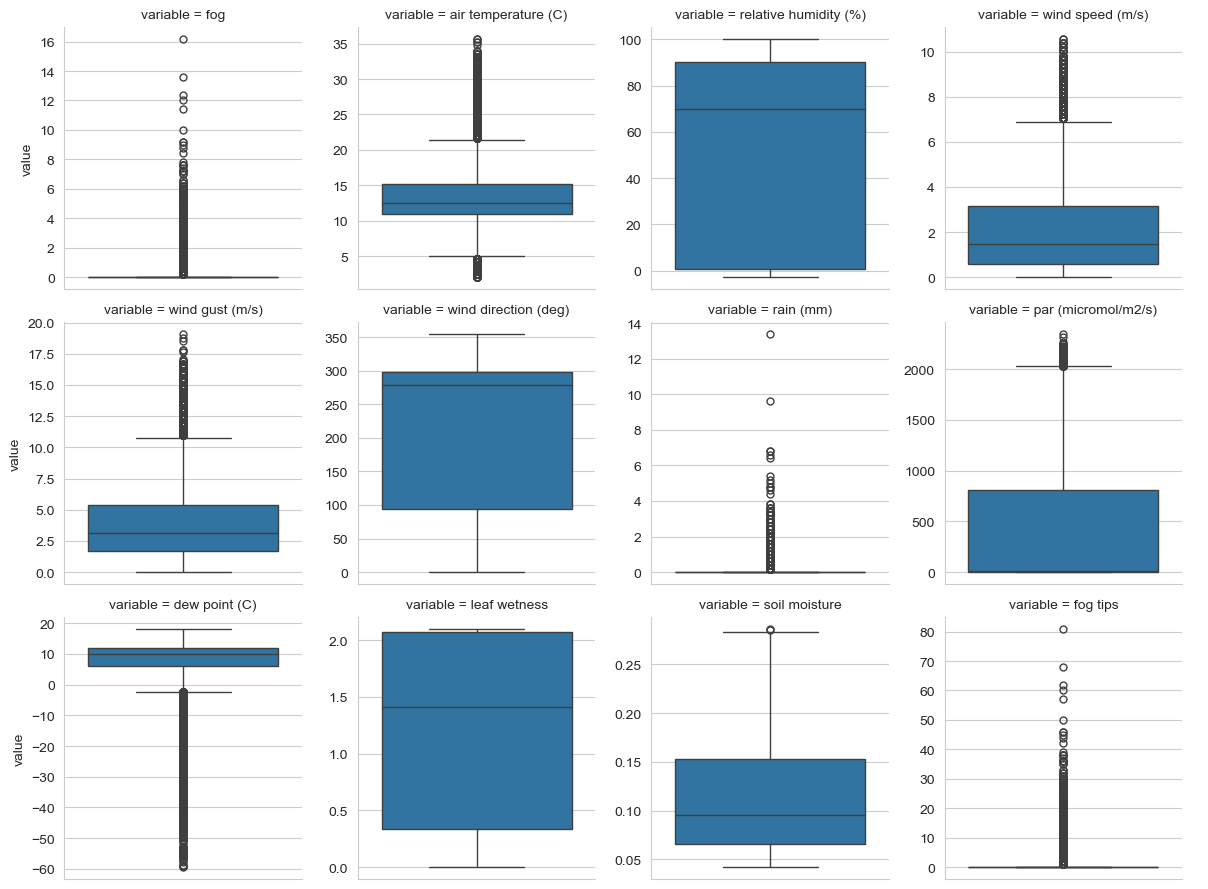

In [124]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [125]:
#### Chekc the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),leaf wetness,soil moisture,fog tips
count,70677,70677.000000,67161.000000,67164.000000,70677.000000,70676.000000,70676.000000,70677.000000,70677.000000,47237.000000,65309.000000,70677.000000,70677.000000
mean,2005-09-17 06:30:50.477524480,0.043318,13.273989,53.447215,1.968641,3.766655,205.608514,0.015514,434.213252,7.392339,1.217442,0.108357,0.216591
min,2004-09-13 18:30:00,0.000000,2.030000,-2.750000,0.000000,0.000000,0.000000,0.000000,1.300000,-59.400002,0.000600,0.041930,0.000000
25%,2005-03-17 07:45:00,0.000000,10.990000,0.750000,0.560000,1.670000,94.099998,0.000000,1.300000,6.110000,0.335100,0.065690,0.000000
50%,2005-09-17 09:00:00,0.000000,12.550000,69.750000,1.480000,3.150000,279.399990,0.000000,11.300000,9.920000,1.411700,0.094960,0.000000
75%,2006-03-20 10:15:00,0.000000,15.230000,90.250000,3.150000,5.380000,297.600010,0.000000,813.799990,11.880000,2.068500,0.153070,0.000000
max,2006-09-20 12:00:00,16.200000,35.700001,100.250000,10.580000,19.110001,355.200010,13.402999,2348.800000,18.209999,2.100200,0.286690,81.000000
std,NaN,0.339032,4.021489,39.651086,1.731356,2.771064,104.382258,0.165668,624.322361,7.929387,0.825776,0.048855,1.695161


### Constrain RH
Ensure all values are between 0 and 100

In [126]:
df['relative humidity (%)'] = df['relative humidity (%)'].clip(lower=0, upper=100)

### Check leaf wetness values - is there a clear response to moisture? 
The pattern is odd, or now I'm not going to include LW in the output. 

<Axes: xlabel='condition', ylabel='leaf wetness'>

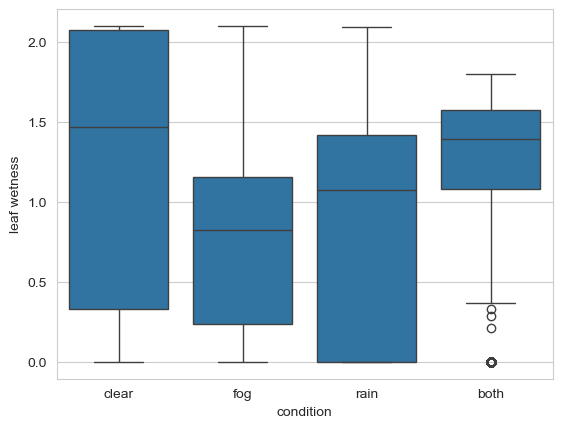

In [127]:
def label_condition(df):
    df['condition'] = 'clear'
    for index, row in df.iterrows():
        condition='clear'
        if row['fog tips'] > 0:
            df.loc[index, 'condition'] = 'fog'

        if row['rain (mm)'] > 0:
            df.loc[index, 'condition'] = 'rain'
        
        if (row['rain (mm)'] > 0) & (row['fog tips'] > 0):
            df.loc[index, 'condition'] = 'both'
    
    return df
tmp = df[['fog tips', 'rain (mm)', 'leaf wetness']].copy()
tmp = label_condition(tmp)

sns.boxplot(data=tmp,
            x='condition',
            y='leaf wetness')

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.


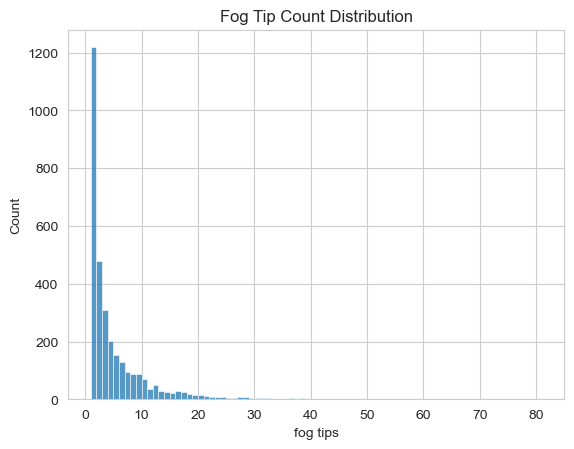

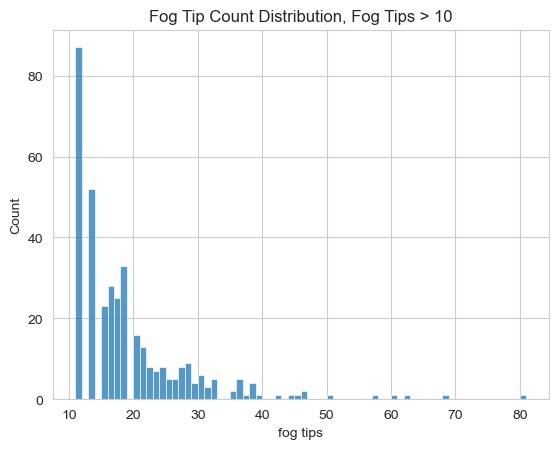

In [128]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

In [129]:
df.head()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),leaf wetness,soil moisture,fog tips
15472,2004-09-13 18:30:00,0.0,16.760000,92.75,4.64,6.49,297.60001,0.0,1.3,15.60,1.1847,0.21288,0.0
15473,2004-09-13 18:45:00,0.0,16.379999,92.75,3.90,6.49,304.70001,0.0,1.3,15.22,1.1224,0.20822,0.0
15474,2004-09-13 19:00:00,0.0,16.379999,93.25,4.45,7.24,300.39999,0.0,1.3,15.31,1.0468,0.20525,0.0
15475,2004-09-13 19:15:00,0.0,16.379999,93.75,4.08,6.68,297.60001,0.0,1.3,15.39,1.0150,0.20270,0.0
15476,2004-09-13 19:30:00,0.0,16.379999,93.75,3.90,5.75,299.00000,0.0,1.3,15.39,1.0211,0.20016,0.0


### Save out cleaned data

In [130]:
#### Save out cleaned data ####
df.to_csv(outfpath)
print(outfpath)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis/data/02-clean/sci-crak-clean.csv
